# San Francisco Rental Prices Dashboard

In this notebook, you will compile the visualizations from the previous analysis into functions that can be used for a Panel dashboard.

In [4]:
# imports
import panel as pn
pn.extension('plotly')
import plotly.express as px
import pandas as pd
import hvplot.pandas
import matplotlib.pyplot as plt
import os
from pathlib import Path
from dotenv import load_dotenv
from panel.interact import interact

In [5]:
# Read the Mapbox API key
load_dotenv()
map_box_api = os.getenv("mapbox")
px.set_mapbox_access_token(map_box_api)

# Import Data

In [6]:
# Import the necessary CSVs to Pandas DataFrames
file_path = Path("sfo_neighborhoods_census_data.csv")
sfoData = pd.read_csv(file_path, index_col="year")

file_path = Path("neighborhoods_coordinates.csv")
neighborhoodLocations = pd.read_csv(file_path)

- - -

## Panel Visualizations

In this section, you will copy the code for each plot type from your analysis notebook and place it into separate functions that Panel can use to create panes for the dashboard. 

These functions will convert the plot object to a Panel pane.

Be sure to include any DataFrame transformation/manipulation code required along with the plotting code.

Return a Panel pane object from each function that can be used to build the dashboard.

Note: Remove any `.show()` lines from the code. We want to return the plots instead of showing them. The Panel dashboard will then display the plots.

In [59]:
# Define Panel Visualization Functions
def housing_units_per_year():
    """Housing Units Per Year."""
    housingUnits = sfoData["housing_units"]
    housingUnits = housingUnits.groupby([sfoData.index]).mean()
    
    housingUnitsFigure = plt.figure()
    housingUnitsPlot = housingUnits.plot.bar(x='year', ylim=[370000, 385000], title="Average Number of Housing Units Sold per Year")
    plt.close(housingUnitsFigure)
    
    return pn.pane.Matplotlib(housingUnitsFigure)

def average_gross_rent():
    """Average Gross Rent in San Francisco Per Year."""
    
    averageRent = sfoData["gross_rent"].groupby([sfoData.index]).mean()
    
    rentFigure = plt.figure()
    averageRentPlot = (averageRent.plot.line(x='year', y='gross_rent', title="Average Goss Rent per Year"))
    plt.close(rentFigure)
    
    return pn.pane.Matplotlib(rentFigure)



def average_sales_price():
    """Average Sales Price Per Year."""
   
    averagePrice = sfoData["sale_price_sqr_foot"].groupby([sfoData.index]).mean()
    salesPriceFigure = plt.figure()
    averagePricePlot = (averagePrice.plot.line(x='year', y='sale_price_sqr_foot', title="Average Sales Price per Year"))
    plt.close(salesPriceFigure)
    
    return pn.pane.Matplotlib(salesPriceFigure)



def average_price_by_neighborhood():
    """Average Prices by Neighborhood."""
    
    costs= sfoData.groupby([sfoData.index, "neighborhood"]).mean()
    costs.reset_index(inplace=True)
    costs.rename(columns={"level_0":"year"}, inplace=True)
    
    avgPrice = costs.hvplot.line("year","sale_price_sqr_foot",xlabel="Year",ylabel= "Avg Sale Per Sqr Foot",groupby="neighborhood",)
    return avgPrice


    



def top_most_expensive_neighborhoods():
    """Top 10 Most Expensive Neighborhoods."""

    avgValue = sfoData.groupby([sfoData.index,"neighborhood"]).mean()
    avgValue = avgValue.reset_index()
    avgValue.rename(columns={"level_0":"year"},inplace=True)
    topTenPlot = avgValue.hvplot.line("year", "sale_price_sqr_foot", xlabel="Year", ylabel="Avg Sale Price Per Sqr Foot", groupby="neighborhood",)
   

    return topTenPlot


def most_expensive_neighborhoods_rent_sales():
    """Comparison of Rent and Sales Prices of Most Expensive Neighborhoods."""   
    costs= sfoData.groupby([sfoData.index, "neighborhood"]).mean()
    costs.reset_index(inplace=True)
    costs.rename(columns={"level_0":"year"},inplace=True)
    rentSalesPlot = costs.hvplot.bar("year", ["gross_rent", "sale_price_sqr_foot"], title="Top10 Expensice Neighborhoods in SFO", xlabel="Neighborhood", ylabel="Number Housing Units",groupby='neighborhood',height=500,rot=100)
    return rentSalesPlot
    

    
    
def parallel_coordinates():
    """Parallel Coordinates Plot."""

    avgValue = sfoData.groupby([sfoData["neighborhood"]]).mean()    
    topTen = avgValue.nlargest(10, 'sale_price_sqr_foot').reset_index()
    topTenParallel = px.parallel_coordinates(
    topTen, 
    color='sale_price_sqr_foot')

    return topTenParallel



def parallel_categories():
    """Parallel Categories Plot."""

    avgValue = sfoData.groupby([sfoData["neighborhood"]]).mean()  
    top10 = avgValue.nlargest(10, 'sale_price_sqr_foot').reset_index()
    topTenCategories = px.parallel_categories(
    top10,
    dimensions=["neighborhood", "sale_price_sqr_foot", "housing_units", "gross_rent"],
    color="sale_price_sqr_foot",
    color_continuous_scale=px.colors.sequential.Inferno,
)

    return topTenCategories


def neighborhood_map():
    """Neighborhood Map."""

    px.set_mapbox_access_token(map_box_api)
    allNeighborhoods = sfoData.groupby(by="neighborhood").mean()
    allNeighborhoods.reset_index(inplace=True)
    allNeighborhoods.rename(columns={"neighborhood":"Neighborhood"},inplace=True)
    allNeighborhoods = pd.merge(allNeighborhoods, neighborhoodLocations,on="Neighborhood")
 
    

    return allNeighborhoods


def sunburst():
    """Sunburst Plot."""
    fig = px.sunburst(most_expensive_neighborhoods_rent_sales, path=["year","neighborhood"], values="sale_price_sqr_foot", color="gross_rent",color_continuous_scale="Blues", title = "Cost Analysis of Most Expensive Neighborhoods in SFO") 
    
    return fig

## Panel Dashboard

In this section, you will combine all of the plots into a single dashboard view using Panel. Be creative with your dashboard design!

In [62]:
# Create a Title for the Dashboard
title = "San Francisco from 2010-2016"


# Create a tab layout for the dashboard
welcomeTab = pn.Row(pn.Column(title), neighborhood_map())

marketAnalysisRow = pn.Row(housing_units_per_year(), average_gross_rent(), average_sales_price())


neighborhoodAnalysisTab = pn.Column(most_expensive_neighborhoods_rent_sales,
    top_most_expensive_neighborhoods()
)

parallelPlotTab = pn.Column( 
    parallel_categories(),
    parallel_coordinates()
)



# Create the dashboard
SanFran = pn.Tabs(("Welcome", welcomeTab), ("Market Analysis", marketAnalysisRow), ("Neighborhood Analysis", neighborhoodAnalysisTab), ("Interactive Market Analysis By Neighborhood", parallelPlotTab))

## Serve the Panel Dashboard

Tabs
    [0] Row
        [0] Column
            [0] Markdown(str)
        [1] DataFrame(DataFrame)
    [1] Row
        [0] Matplotlib(Figure)
        [1] Matplotlib(Figure)
        [2] Matplotlib(Figure)
    [2] Column
        [0] Column
            [0] Column()
            [1] Row
                [0] Row(name='interactive04941')
                    [0] HoloViews(DynamicMap, name='interactive04941')
                    [1] Column
                        [0] WidgetBox
                            [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                        [1] VSpacer()
        [1] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] Select(margin=(20, 20, 20, 20), name='neighborhood', options=['Alamo Square', ...], value='Alamo Square', width=250)
                [1] VSpacer()
    [3] Column
        [0] Plotly(Figure)
        [1] Plotly(Figure)
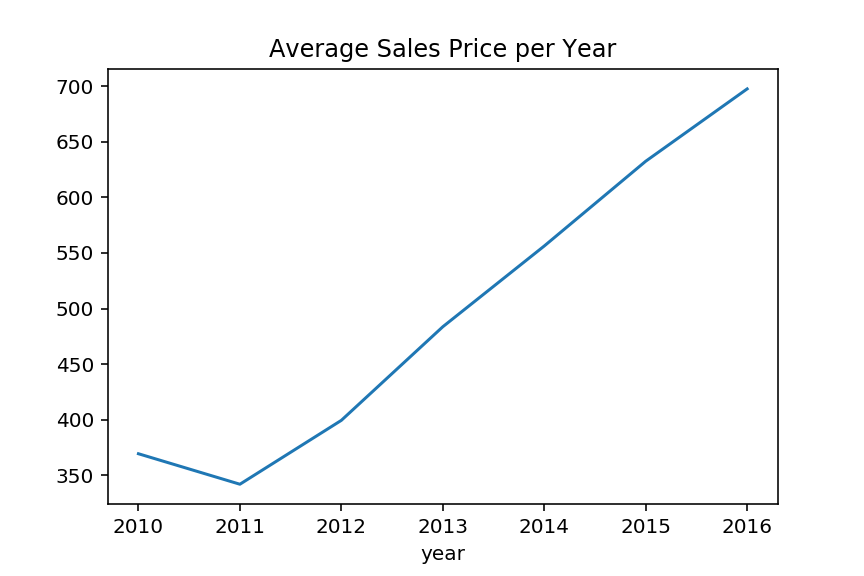
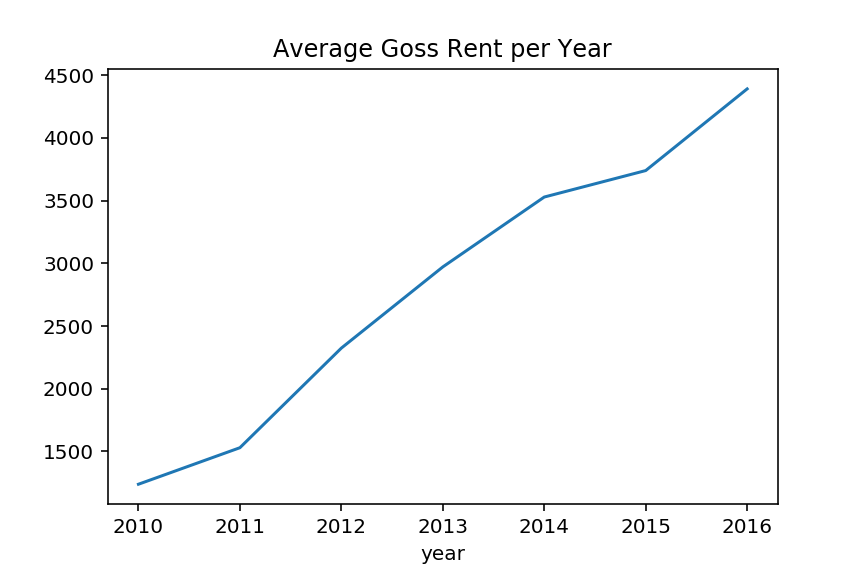
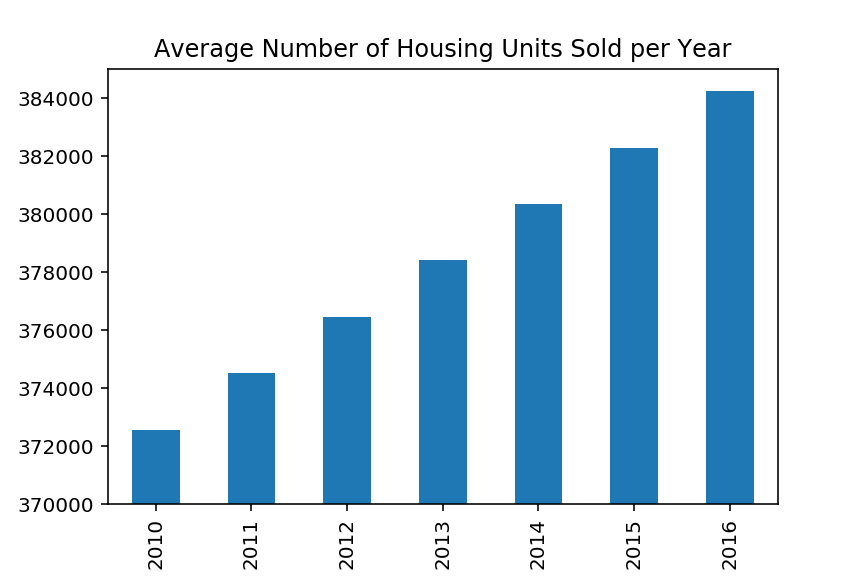

In [63]:
# Serve the# dashboard
SanFran.servable()

# Debugging

Note: Some of the Plotly express plots may not render in the notebook through the panel functions.

However, you can test each plot by uncommenting the following code

Matplotlib(Figure)
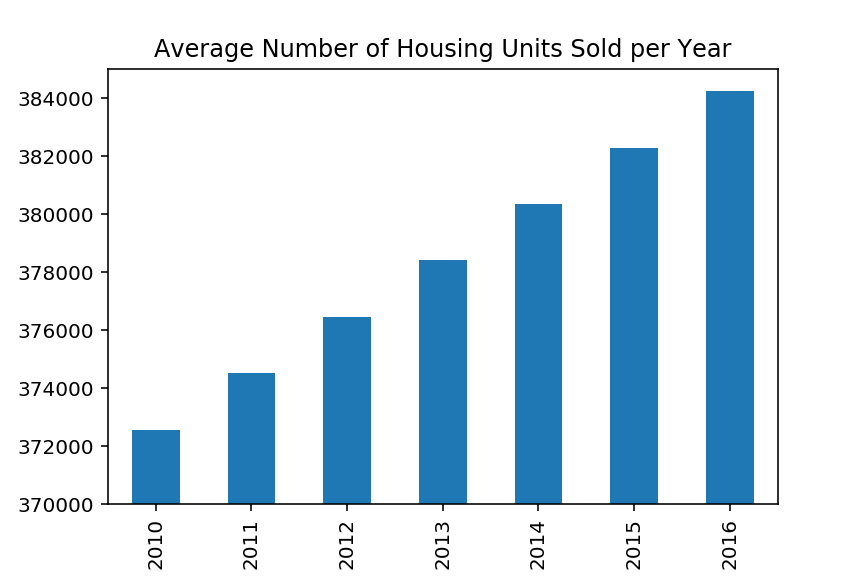

In [55]:
housing_units_per_year()

Matplotlib(Figure)
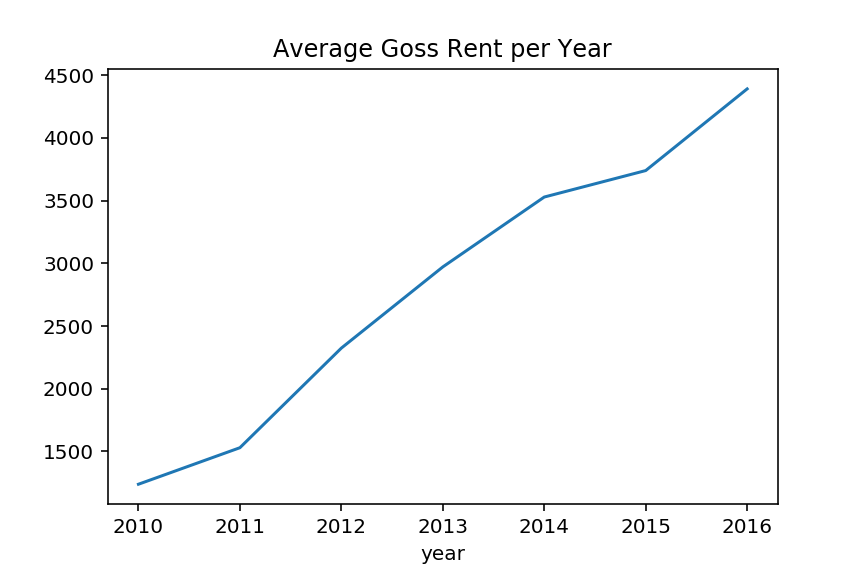

In [56]:
average_gross_rent()

Matplotlib(Figure)
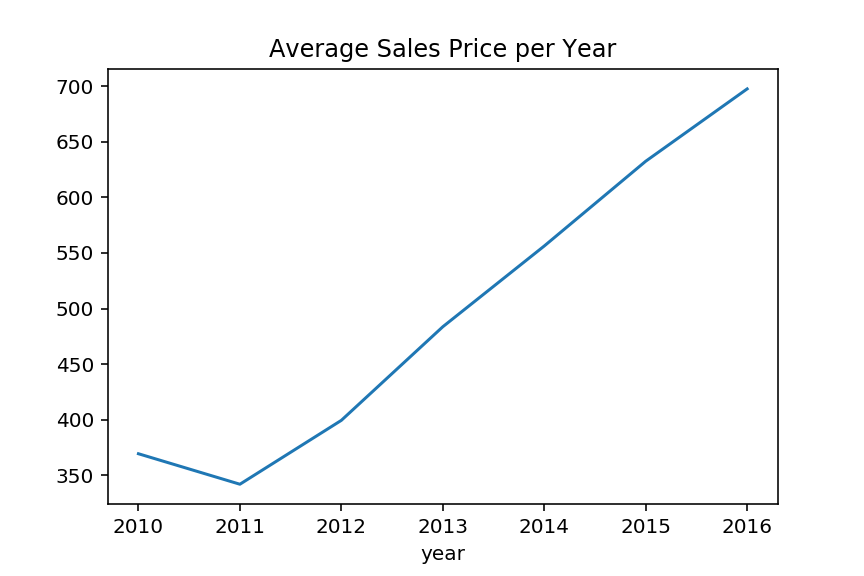

In [57]:
 average_sales_price()

In [64]:
average_price_by_neighborhood()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [65]:
 top_most_expensive_neighborhoods()

:DynamicMap   [neighborhood]
   :Curve   [year]   (sale_price_sqr_foot)

In [66]:
 most_expensive_neighborhoods_rent_sales()

:DynamicMap   [neighborhood]
   :Bars   [year,Variable]   (value)

In [67]:
 neighborhood_map()

,Neighborhood,sale_price_sqr_foot,housing_units,gross_rent,Lat,Lon
0,Alamo Square,366.020712,378401.00,2817.285714,37.791012,-122.402100
1,Anza Vista,373.382198,379050.00,3031.833333,37.779598,-122.443451
2,Bayview,204.588623,376454.00,2318.400000,37.734670,-122.401060
3,Bayview Heights,590.792839,382295.00,3739.000000,37.728740,-122.410980
4,Buena Vista Park,452.680591,378076.50,2698.833333,37.768160,-122.439330
...,...,...,...,...,...,...
64,West Portal,498.488485,376940.75,2515.500000,37.740260,-122.463880
65,Western Addition,307.562201,377427.50,2555.166667,37.792980,-122.435790
66,Westwood Highlands,533.703935,376454.00,2250.500000,37.734700,-122.456854
67,Westwood Park,687.087575,382295.00,3959.000000,37.734150,-122.457000


In [68]:
 parallel_categories()

In [69]:
 parallel_coordinates()

In [21]:
sunburst()

NameError: name 'rentSalesPlot' is not defined